# The Effectiveness of Edge Detection Evaluation Metrics for Automated Coastline Detection
<br>
Conor O'Sullivan 
<br>
27 Feb 2023

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import cv2
import glob
from skimage import feature

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqi

# Import helper functions from utils.py
import utils 

#Save path 
save_path = '/Users/conorosullivan/Google Drive/My Drive/UCD/research/Evaluation metrics/'

# Global variables
channels = ['Coastal \nAerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water \nVapour','SWIR 1','SWIR 2']

thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]

In [12]:
# Reload utils
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL MONITORING/edge-detection-metrics/src/utils.py'>

## Load images and edge reference

In [2]:
test_path = glob.glob("../../data/SWED/test/images/*")
print(test_path[0])
print(len(test_path))

# Initialise data processing class
processor = utils.data_processor()

# Load all images and labels
input = []
rgb = []
labels = []

for path in test_path:
    try:
        img, rgb_img, label = processor.load_test(path)
    
        input.append(img)
        labels.append(label)
        rgb.append(rgb_img)
    except:
        print("Error with image: ", path)

# Apply canny edge detection to binary maps to get reference edges
canny_input = [np.uint8(img*255) for img in labels]
edge_reference = [np.uint8(cv2.Canny(img,threshold1 = 100, threshold2 = 200)) for img in canny_input]

../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
98


0 255


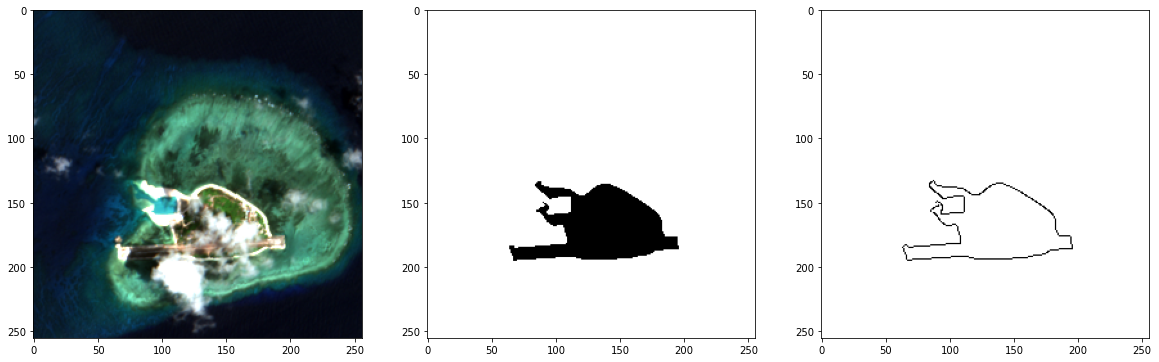

In [3]:
# Sense check edge references
rint = np.random.randint(0,len(edge_reference))

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(rgb[rint])
ax[1].imshow(labels[rint], cmap='gray')
ax[2].imshow(255-edge_reference[rint], cmap='gray')

print(np.min(edge_reference[rint]) ,np.max(edge_reference[rint]))

## Apply canny edge detection and evaluation metrics

In [4]:
# Apply canny edge detection with different intensity thresholds
canny_input = input.copy()
canny = {}

for threshold in thresholds:
        t1 = threshold[0]
        t2 = threshold[1]
        canny[str(threshold)] = [processor.canny_ed(img,threshold1=t1,threshold2=t2) for img in canny_input]

        print(threshold, len(canny[str(threshold)]),'done')

[50, 100] 98 done
[50, 150] 98 done
[100, 200] 98 done
[100, 300] 98 done
[200, 400] 98 done
[200, 600] 98 done


In [6]:
# Evaluate canny edge detection with rmse, psnr, uqi, ssim and fom
rows = []

for threshold in thresholds:
    canny_output = canny[str(threshold)]

    for i, output in enumerate(canny_output):
        ref_img = edge_reference[i]
        ID = "IMG#{}".format(i)

        for j in range(len(channels)):
                
            img = output[:,:,j]

            # Evaluation metrics
            rmse_ = rmse(ref_img,img)
            psnr_ = psnr(ref_img,img)
            uqi_ = uqi(ref_img,img)
            ssim_ = ssim(ref_img,img,multichannel=True)
            fom_ = processor.fom(ref_img,img)
            tp_,fp_,tn_,fn_,tpr_,fpr_,tnr_,fnr_,fp_fn_ratio_ = processor.get_rates(ref_img,img)

            # detect edges as a percentage of reference edges
            pde_ = np.count_nonzero(img)/np.count_nonzero(ref_img)
            
            row = [ID,str(threshold),j+ 1,rmse_,psnr_,uqi_,ssim_,fom_,tp_,fp_,tn_,fn_,tpr_,fpr_,tnr_,fnr_,fp_fn_ratio_,pde_]
            rows.append(row)

    print(threshold,'done')
    
df_metrics = pd.DataFrame(rows,columns = ['ID',"thresholds","band","rmse","psnr","uqi","ssim","fom","tp","fp","tn","fn","tpr","fpr","tnr","fnr","fp_fn_ratio","pde"])
df_metrics.to_csv(save_path+"canny_evaluation_metrics.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_71413/3038344124.py:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


[50, 100] done


KeyboardInterrupt: 

## Analyse metric trend

In [21]:
df_metrics = pd.read_csv(save_path+"canny_evaluation_metrics.csv",index_col=0)

# Initialise visualisation class
importlib.reload(utils)
viz = utils.data_visualizer(df_metrics,canny,edge_reference,thresholds,channels)

In [16]:
# NIR table 
df_metrics_nir = df_metrics[df_metrics['band']==7]

df_mean = df_metrics_nir[['thresholds', 'rmse','psnr','ssim','fom']].groupby('thresholds').mean().reset_index()
df_mean['threshold 1'] = df_mean['thresholds'].apply(lambda x: int(x.split(',')[0][1:]))
df_mean['threshold 2'] = df_mean['thresholds'].apply(lambda x: int(x.split(',')[1][:-1]))

df_mean = df_mean.sort_values(by=['threshold 1','threshold 2'])[['threshold 1','threshold 2','rmse','psnr','ssim','fom']]
df_mean.columns = ['Threshold 1','Threshold 2','RMSE','PSNR','SSIM','FOM']
df_mean = df_mean.round(2)

df_mean.to_clipboard(index=False)

df_mean.head()

,Threshold 1,Threshold 2,RMSE,PSNR,SSIM,FOM
4,50,100,74.02,11.06,0.70,0.31
5,50,150,67.16,11.92,0.75,0.34
0,100,200,55.93,13.48,0.82,0.40
1,100,300,48.23,14.76,0.86,0.42
2,200,400,39.83,16.39,0.90,0.33


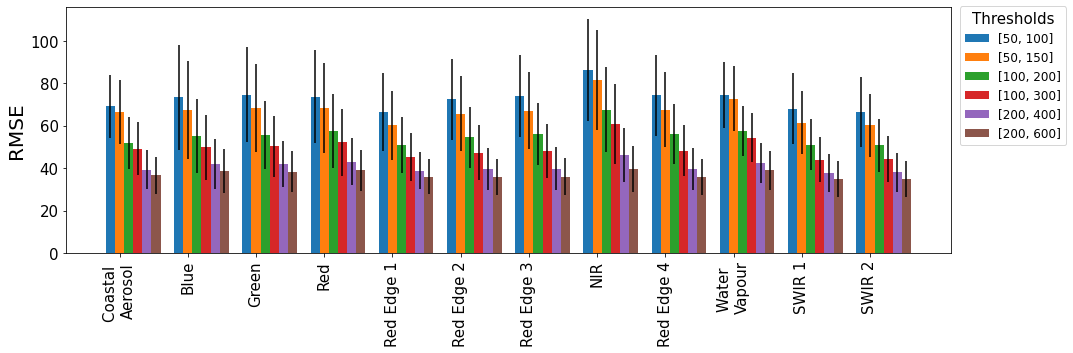

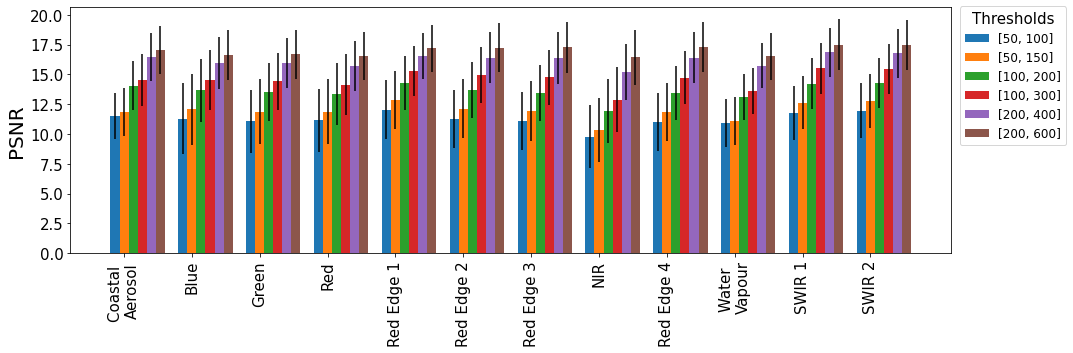

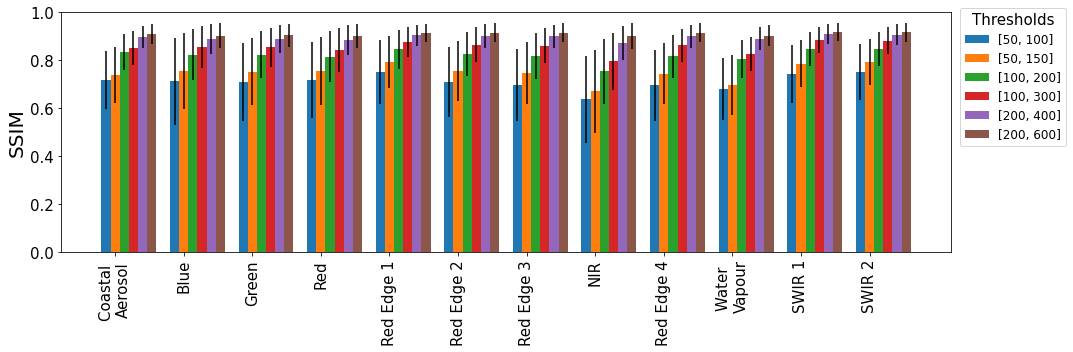

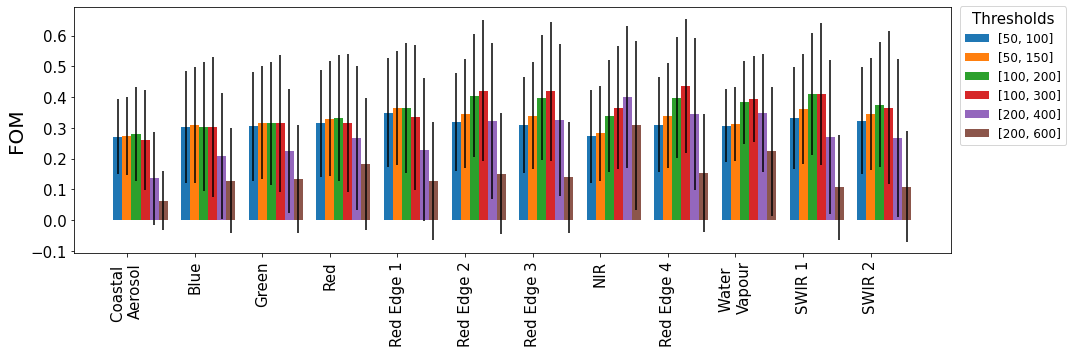

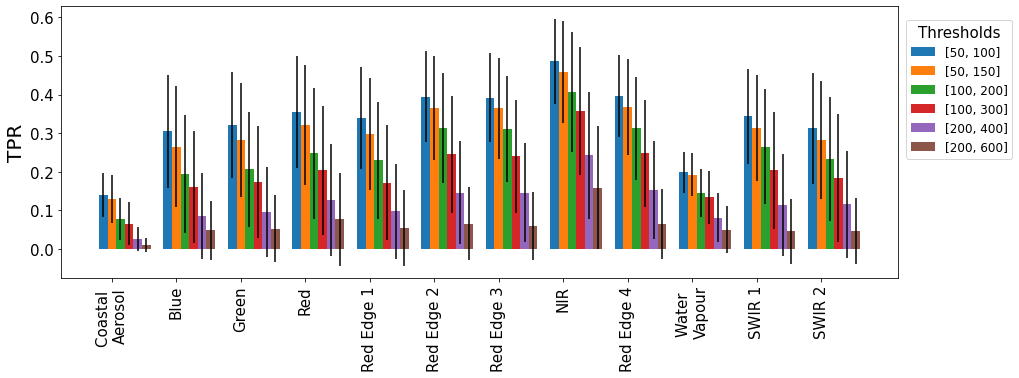

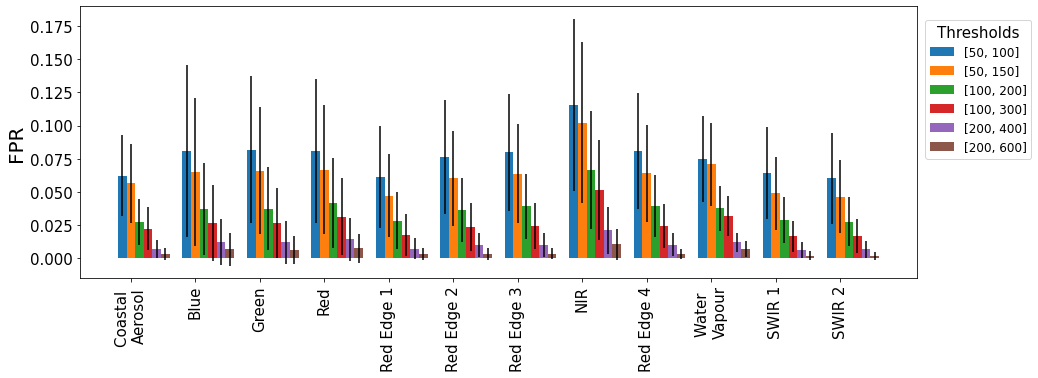

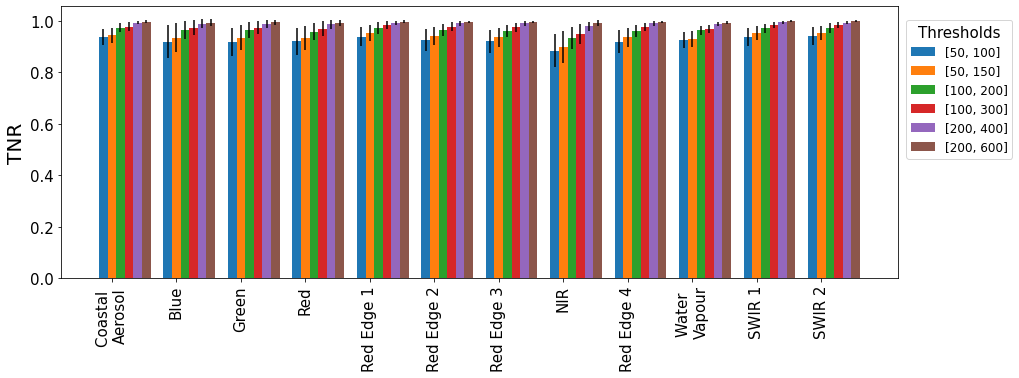

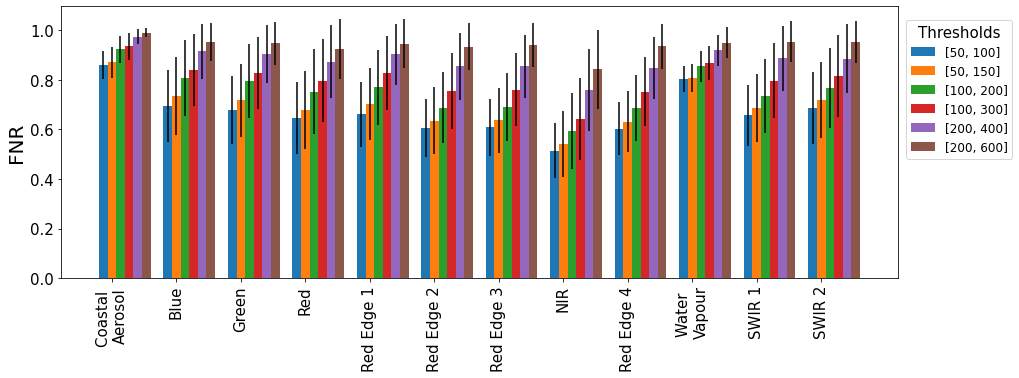

In [18]:
# metric trends
viz.plot_metric_trends('rmse',save_path=save_path+"Figures/rmse.png")
viz.plot_metric_trends('psnr',save_path=save_path+"Figures/psnr.png")
viz.plot_metric_trends('ssim',save_path=save_path+"Figures/ssim.png")
viz.plot_metric_trends('fom',save_path=save_path+"Figures/fom.png")
viz.plot_metric_trends('tpr')
viz.plot_metric_trends('fpr')
viz.plot_metric_trends('tnr')
viz.plot_metric_trends('fnr')


In [19]:
# counts of best thresholds
best_threshold_count = pd.DataFrame(thresholds,columns=['threshold1','threshold2'])

for metric in ['rmse','psnr','ssim','fom']:

    df = df_metrics[['ID','thresholds',metric]]

    if metric == 'rmse':
        best_thresholds = df.loc[df.groupby('ID')[metric].idxmin()]
    else:
        best_thresholds = df.loc[df.groupby('ID')[metric].idxmax()]

    count = []
    for threshold in thresholds:
        df = best_thresholds[best_thresholds['thresholds']==str(threshold)]
        count.append(len(df))

    best_threshold_count[metric] = count

best_threshold_count.columns = ['Threshold 1','Threshold 2','RMSE','PSNR','SSIM','FOM']

best_threshold_count.to_clipboard(index=False)
best_threshold_count.head()

,Threshold 1,Threshold 2,RMSE,PSNR,SSIM,FOM
0,50,100,0,0,0,2
1,50,150,0,0,0,7
2,100,200,2,2,2,12
3,100,300,1,1,3,31
4,200,400,4,4,20,30


## Visual analysis of best thresholds

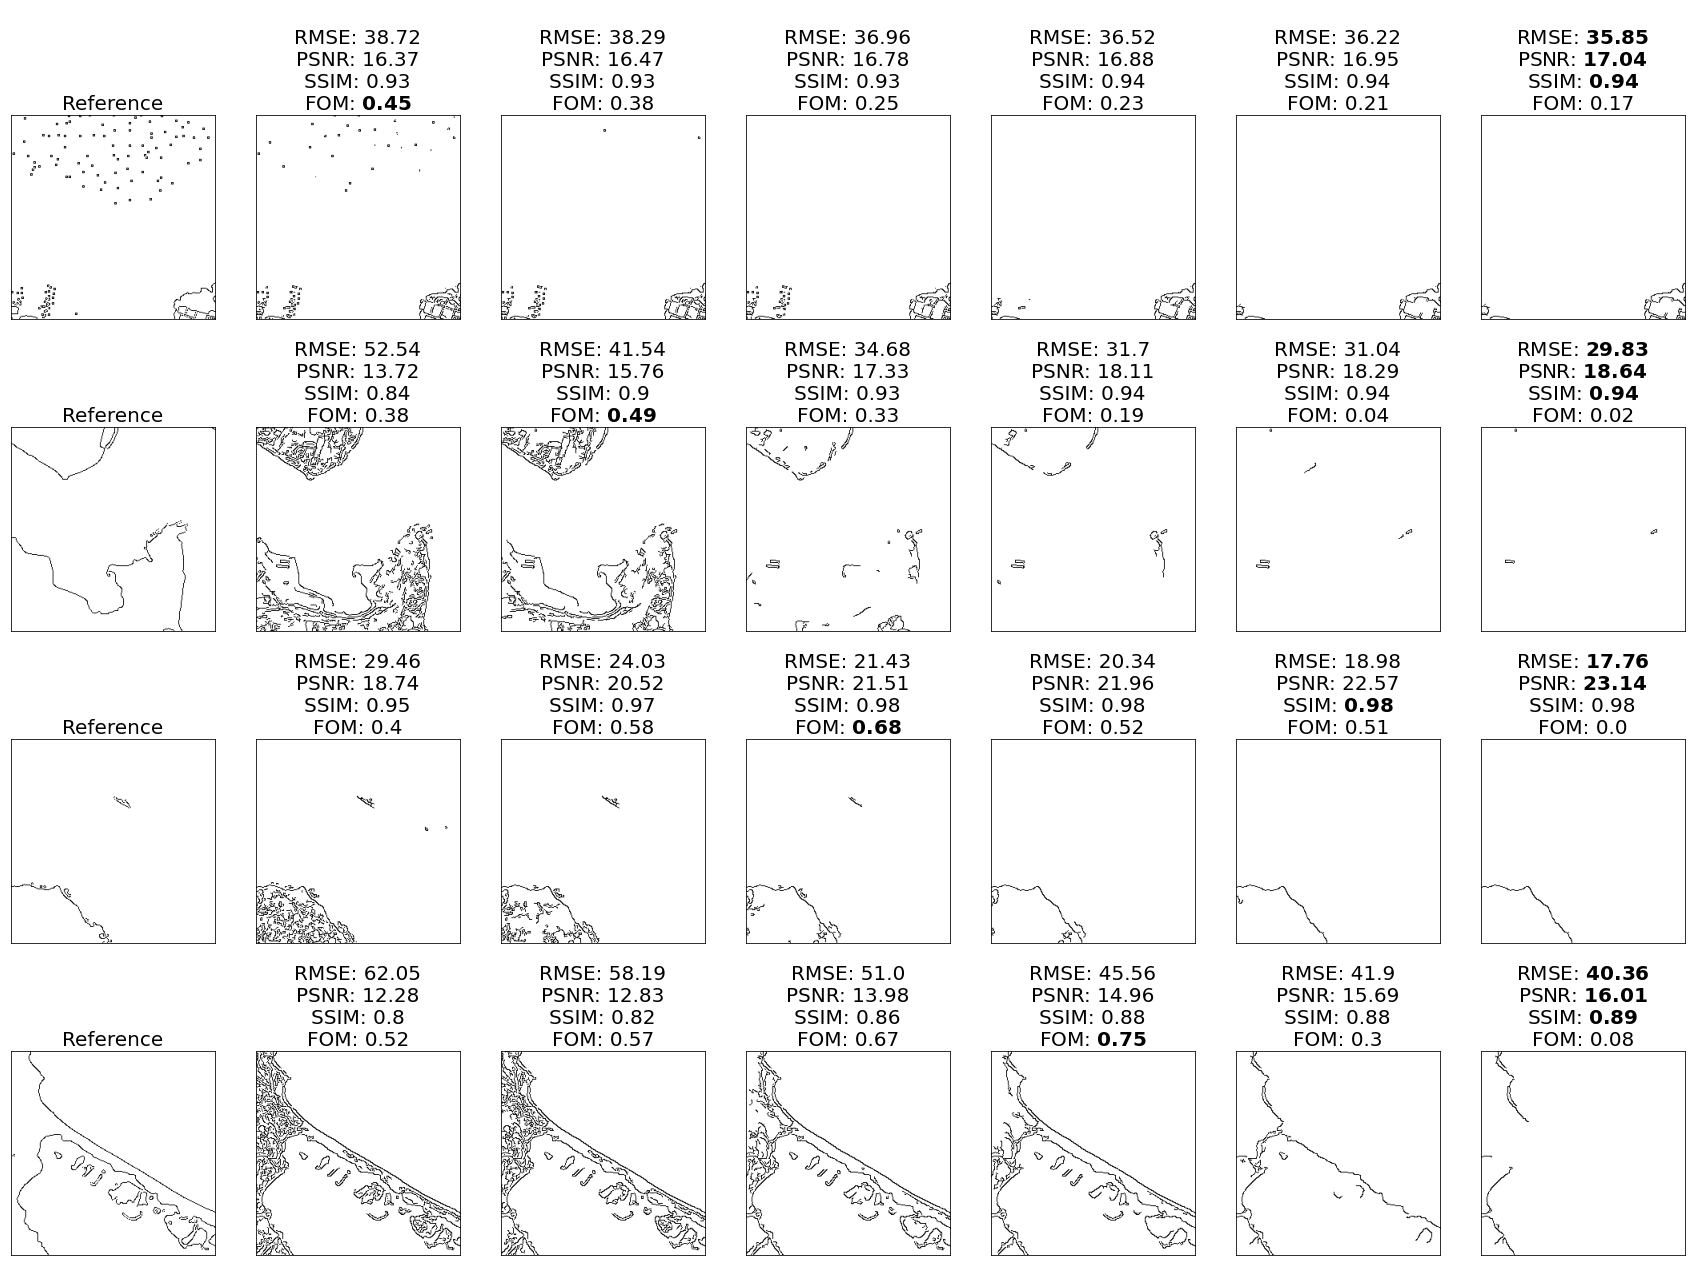

In [30]:
IDs = [74,40,2,68]
viz.example_plots(IDs,save_path=save_path+"Figures/good_examples.png")

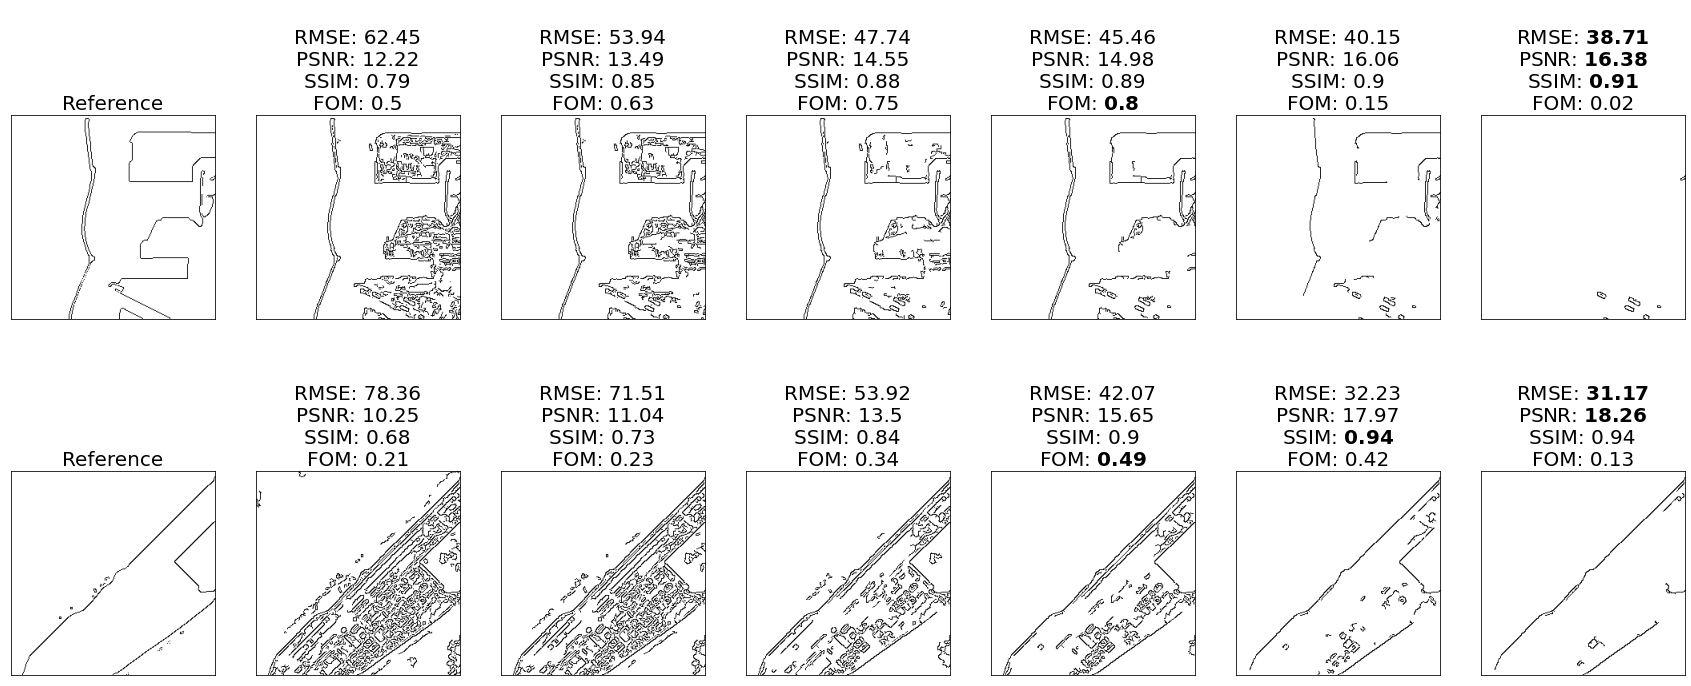

In [32]:
IDs = [15,22]
viz.example_plots(IDs,save_path=save_path+"Figures/bad_examples.png")

## Reason for metric failure 

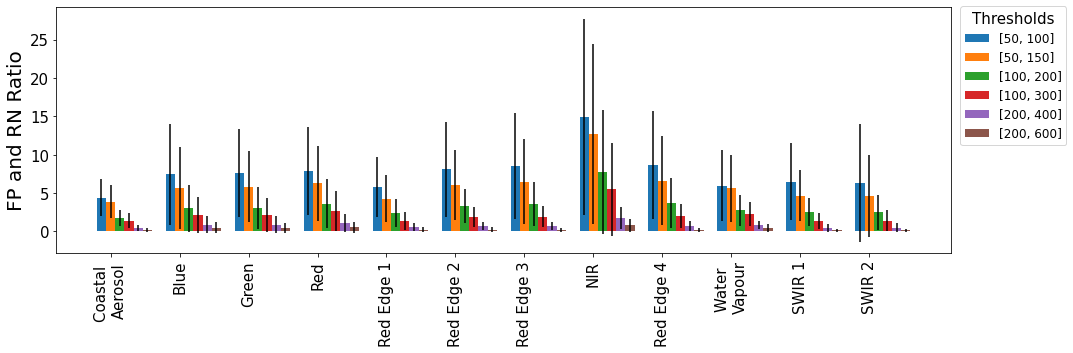

In [34]:
viz.plot_metric_trends('fp_fn_ratio',ylabel="FP and RN Ratio", save_path = save_path+"Figures/fp_fn_ratio.png")

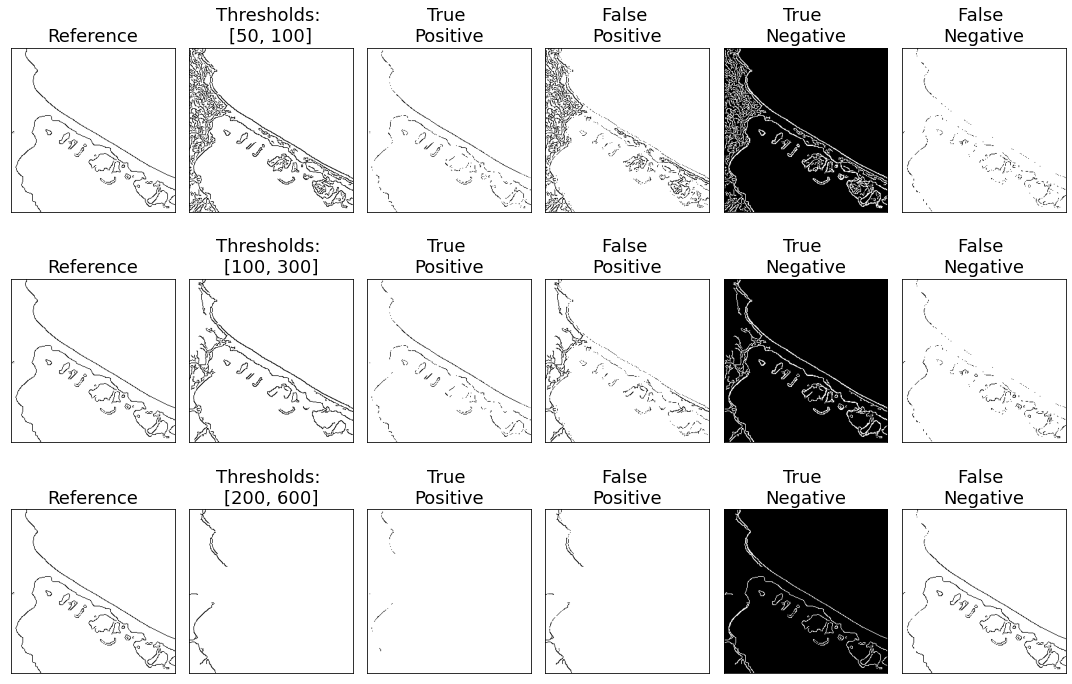

In [14]:
rint = random.randint(0,len(edge_reference))
rint = 68 
band = 7 
threshold = [100,300]

fig, axs = plt.subplots(3,6, figsize=(15,10))
fig.set_facecolor('white')

for i, threshold in enumerate([[50,100],[100,300],[200,600]]):
    reference = edge_reference[rint]*1.0
    reference = np.array(reference)

    detected =  canny[str(threshold)][rint][:,:,band]*1.0
    detected = np.array(detected)

    # True Positive
    TP = reference - (255-detected)
    TP[TP<0] = 0

    # False Positive
    FP = detected - TP

    # False negatives
    N = 255 - detected
    FN = N - (255-reference)

    # True Negative
    TN  = (255-reference) -detected
    TN[TN<0] = 0

    # False Negative
    FN = (255-detected) - (255-reference)
    FN[FN<0] = 0

    axs[i,0].imshow(255-reference,cmap="gray")
    axs[i,0].set_title("Reference",size=18)

    axs[i,1].imshow(255-detected,cmap="gray")
    axs[i,1].set_title("Thresholds: \n{}".format(threshold),size=18)

    axs[i,2].imshow(255-TP,cmap="gray")
    axs[i,2].set_title("True \nPositive",size=18)

    axs[i,3].imshow(255-FP,cmap="gray")
    axs[i,3].set_title("False \nPositive",size=18)

    axs[i,4].imshow(255-TN,cmap="gray")
    axs[i,4].set_title("True \nNegative",size=18)

    axs[i,5].imshow(255-FN,cmap="gray")
    axs[i,5].set_title("False \nNegative",size=18)

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.savefig(save_path+"Figures/TP_FP_example.png",dpi=300)

# Figure for abstract

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(30, 20))
fig.set_facecolor('white')
#rint = np.random.randint(0, len(input))
rint = 67

thresholds = [[50,100],[100,200],[200,400]]

band = 10 

img_input = input[rint].copy()
#img_input = preprocess(img_input,[False,False,False])

axs[0].imshow(img_input[:,:,band],cmap="gray")
axs[0].set_title("Input Image",size=25)

ref_img = edge_reference[rint]
axs[1].imshow(255-ref_img,cmap="gray")
axs[1].set_title("Edge \nReference",size=25)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

for i,threshold in enumerate(thresholds):
        
    t1 = threshold[0]
    t2 = threshold[1]
    canny = utils.canny_ed(img_input,threshold1=t1,threshold2=t2)
    img = canny[:,:,band]
    
    axs[i+2].imshow(255-img,cmap="gray")
    rmse_ = round(rmse(ref_img,img),2)
    psnr_ = round(psnr(ref_img,img),2)
    ssim_ = round(ssim(ref_img,img,multichannel=True),2)
    fom_ = round(utils.fom(ref_img,img),2)

    if i == 0:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: {}".format(rmse_,psnr_,ssim_,fom_),size=20)
    elif i == 1:
        axs[i+2].set_title("\nRMSE: {}\nPSNR: {}\nSSIM: {}\nFOM: ".format(rmse_,psnr_,ssim_)+ r"$\bf{" + str(fom_) + "}$",size=20)
    else:
        axs[i+2].set_title("\nRMSE: " + r"$\bf{" + str(rmse_) + "}$" + 
        "\nPSNR: " + r"$\bf{" + str(psnr_) + "}$" +
        "\nSSIM: " + r"$\bf{" + str(ssim_) + "}$" +
        "\nFOM: " +str(fom_),size=20)

    #plt.savefig(fig_path.format("abstract.png"),bbox_inches="tight")    